# Image Classification using Keras and sklearn

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns # statistical data visualization, used to plot total count for each label
import random # used to split trainig and testing data
import warnings
import os # used to iterate through all the images in the specified directory
import cv2

# libraries used for loading images and visualization
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

# libraries to split the data into training and testing data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn import utils

import PIL
from PIL import Image

# libraries to build the model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix

# heatmap analysis libraries
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import tensorflow.keras.backend as K

# import tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


Spiral_DataSet1_relabelled\healthy\V01HE02.png 0
total number of labels:  102
total number of images:  102
                                               images  label
90  Spiral_DataSet1_relabelled\parkinsons\V01PE01.png      1
36      Spiral_DataSet1_relabelled\healthy\V03HE1.png      0
37  Spiral_DataSet1_relabelled\parkinsons\V03PE08.png      1
89  Spiral_DataSet1_relabelled\parkinsons\V09PE02.png      1
60  Spiral_DataSet1_relabelled\parkinsons\V15PE03.png      1
..                                                ...    ...
8   Spiral_DataSet1_relabelled\parkinsons\V03PE01.png      1
25     Spiral_DataSet1_relabelled\healthy\V09HE01.png      0
50     Spiral_DataSet1_relabelled\healthy\V55HE02.png      0
93  Spiral_DataSet1_relabelled\parkinsons\V06PE01.png      1
81      Spiral_DataSet1_relabelled\healthy\V03HE2.png      0

[102 rows x 2 columns]


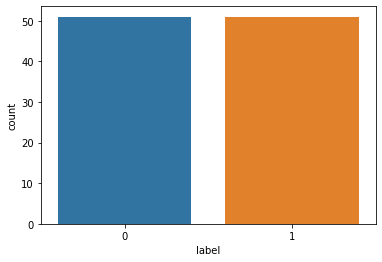

In [2]:
## --------------------------------------------------------
#                  Create the Dataframe
## --------------------------------------------------------
img_path = [] # store image paths for all images (all images are size 256x256)
label = [] # healthy (0) vs parkinsons (1)
dataset_folder = 'Spiral_DataSet1_relabelled'

# iterate through all of the images to create a binary array corresponding to the image labels
for labeled_folder in os.listdir(dataset_folder):
    for img in os.listdir(dataset_folder + "/" + labeled_folder):
        if labeled_folder == 'healthy':
            label.append(0)
        else:
            label.append(1)
        img_path.append(os.path.join(dataset_folder, labeled_folder, img))

# total number of images and labels should match
print(img_path[1], label[1])
print("total number of labels: ", len(label))
print("total number of images: ", len(img_path))

# now create the dataframe
df = pd.DataFrame()
df['images'] = img_path
df['label']  = label


df = df.sample(frac=1).reset_index(drop=True) # randomize the images, rather than having them be in order
df = utils.shuffle(df)

print(df)

# show the total count for each of the labels
sns.countplot(df['label'])
plt.show()

## Split into training, validation, and test data

There is a 70-30 split, and a 15-15 split for validation and test data

In [3]:
## -----------------------------------------------------------
#               Split into test and training data
## -----------------------------------------------------------
#randomly split data in train and test subsets
x_feature, val_feature, x_label, val_label = train_test_split(df['images'], df['label'], test_size=0.30, stratify=df['label'])

# shuffle data
#x_feature, x_label = utils.shuffle(x_feature, x_label)
val_feature, val_label = utils.shuffle(val_feature, val_label)

## (OPTIONAL) split val and test data
val_feature, test_feature, val_label, test_label = train_test_split(val_feature, val_label, test_size=0.5, shuffle=False)

print("# validation samples: ", len(val_label))
print("# testing samples: ", len(test_label))
print('# training samples: ', len(x_label))

print("pause")
# convert y-col to str for binary class_mode
# train['label'] = train['label'].astype('str')
# test['label']  = test['label'].astype('str')

# validation samples:  15
# testing samples:  16
# training samples:  71
pause


## Perform data augmentation to artificially create more data

In [4]:
## ------------------------------------------
#       Convert images to raw pixels
## ------------------------------------------
train_array = []
val_array = []
test_array = []

for img_path in x_feature:
    openImg = PIL.Image.open(img_path)
    # image = openImg.convert("P") # covert to grayscale
    imgArray = np.array(openImg)
    # imgArray = cv2.resize(imgArray, (128,128,3))
    imgArray = np.expand_dims(imgArray, axis=0)

    # store in array
    train_array.append(imgArray)

for img_path in val_feature:
    openImg = PIL.Image.open(img_path)
    # image = openImg.convert("P") # covert to grayscale
    imgArray = np.array(openImg)
    # imgArray = cv2.resize(imgArray, (128,128,3))
    imgArray = np.expand_dims(imgArray, axis=0)

    # store in array
    val_array.append(imgArray)

for img_path in test_feature:
    openImg = PIL.Image.open(img_path)
    # image = openImg.convert("P") # covert to grayscale
    imgArray = np.array(openImg)
    # imgArray = cv2.resize(imgArray, (128,128,3))
    imgArray = np.expand_dims(imgArray, axis=0)

    # store in array
    test_array.append(imgArray)


print("pause")


pause


In [9]:
## -------------------------------------------------------------------
#       Artificially create more images for a bigger dataset
## -------------------------------------------------------------------
# normalize the data
train_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=360,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=360,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

## add more training images
trainAug = []
trainAugLabel = []

for (i,v) in enumerate(x_label):
    #print("i: ", i)
    #print("v: ", v)
    # tempImg = np.expand_dims(train_array[i], axis=0)
    tempImg = train_array[i]
    aug = train_gen.flow(tempImg, batch_size=1, shuffle=True)
    for addImages in range(90):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 256**2 * 3:
            trainAug.append(augImg)
            trainAugLabel.append(v)

## add more validation images
valAug = []
valAugLabel = []

for (i,v) in enumerate(val_label):
    #print("i: ", i)
    #print("v: ", v)
    # tempImg = np.expand_dims(val_array[i], axis=0)
    tempImg = val_array[i]
    aug = test_gen.flow(tempImg, batch_size=1)
    for addImages in range(50):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 256**2 * 3:
            valAug.append(augImg)
            valAugLabel.append(v)

## add more test images
testAug = []
testAugLabel = []

for (i,v) in enumerate(test_label):
    # tempImg = np.expand_dims(test_array[i], axis=0)
    tempImg = test_array[i]
    aug = test_gen.flow(tempImg, batch_size=1)
    for addImages in range(50):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 256**2 * 3:
            testAug.append(augImg)
            testAugLabel.append(v)


trainAugLabel = tf.keras.utils.to_categorical(np.array(trainAugLabel))
valAugLabel = tf.keras.utils.to_categorical(np.array(valAugLabel))
testAugLabel = tf.keras.utils.to_categorical(np.array(testAugLabel))


# shuffle data
trainAug, trainAugLabel = utils.shuffle(trainAug, trainAugLabel)
valAug, valAugLabel = utils.shuffle(valAug, valAugLabel)
testAug, testAugLabel = utils.shuffle(testAug, testAugLabel)


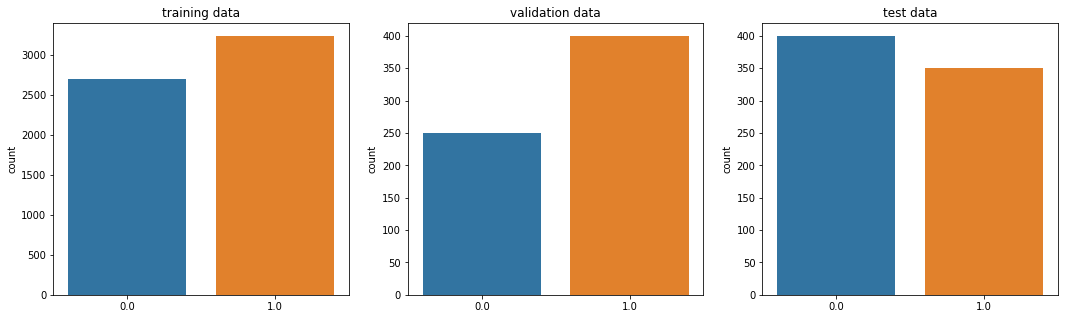

Total training data samples:  5940
Total validation data samples:  650
Total test data samples:  750
Training-to-validation ratio:  11.0 %


In [10]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18,5)
ax0 = sns.countplot(trainAugLabel[:,1], ax=ax[0])
ax0.title.set_text("training data")
ax1 = sns.countplot(valAugLabel[:,1], ax=ax[1])
ax1.title.set_text("validation data")
ax2 = sns.countplot(testAugLabel[:,1], ax=ax[2])
ax2.title.set_text("test data")
plt.show()

print("Total training data samples: ", len(trainAug))
print("Total validation data samples: ", len(valAug))
print("Total test data samples: ", len(testAug))
print("Training-to-validation ratio: ", np.round(len(valAug)/len(trainAug),2)*100 , "%")

In [ ]:
# plot images
imfile = Image.fromarray(np.squeeze(val_array[4]))
imfile.show(imfile)   

## Build a model

In [12]:
reg = tf.keras.regularizers.l2(0.001)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model = Sequential([
    Conv2D(128, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(256,256,3)),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(64, (5,5), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(64, (3,3), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(32, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((2,2), strides=(1,1)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    #Dense(32, activation='relu'),
    Dense(2,activation='softmax')
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainAugLabel, batch_size=128, epochs=35, validation_data=(np.array(valAug), valAugLabel))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 128)     9728      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 63, 63, 64)        204864    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 59, 59, 64)      

In [48]:
## ------------------------------
##           Save the model
## ------------------------------
model.save('20220601_run4.h5')
model.save('20220601_run4.tf')

INFO:tensorflow:Assets written to: 20220601_run4.tf\assets


In [ ]:
## -----------------------------------------------------------
#                       Plot the Results
## -----------------------------------------------------------
# Accuracy and Validation Accuracy
accuracy1 = trained_model.history['accuracy']
val_acc1 = trained_model.history['val_accuracy']
epochs = range(len(accuracy1))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax[0].plot(epochs, accuracy1, 'b', label='Training Accuracy')
ax[0].plot(epochs, val_acc1, 'r', label='Validation Accuracy')
ax[0].title.set_text('Accuracy Graph')
ax[0].legend()
ax[0].grid()

# Loss and Validation Loss
loss1 = trained_model.history['loss']
val_loss1 = trained_model.history['val_loss']

ax[1].plot(epochs, loss1, 'b', label='Training Loss')
ax[1].plot(epochs, val_loss1, 'r', label='Validation Loss')
ax[1].title.set_text('Loss Graph')
ax[1].legend()
ax[1].grid()

## Analysis of results and testing

In [ ]:
loss, acc = model.evaluate(np.array(testAug), testAugLabel, verbose=2)
print(acc)

## Load previous models to test

In [150]:
# # load model and run more epochs
# loadedModel = tf.keras.models.load_model('20220601_run2.tf')
# moreTraining = loadedModel.fit(np.array(trainAug), trainAugLabel, batch_size=128, epochs=5, validation_data=(np.array(valAug), valAugLabel))

# prediction accuracy
testModel = tf.keras.models.load_model('20220601_run2.h5')
testModel.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 31, 31, 64)        204864    
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 27, 27, 64)     

In [301]:
loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)

25/25 - 8s - loss: 0.6276 - accuracy: 0.8087 - 8s/epoch - 326ms/step


In [153]:
# classification report
pred = testModel.predict(np.array(testAug))
pred = np.argmax(pred, axis=1)
label_pred = np.argmax(testAugLabel, axis=1)
print(classification_report(label_pred, pred))

# confusion matrix
cmat = confusion_matrix(label_pred, pred)
print(cmat)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       450
           1       0.91      0.84      0.87       350

    accuracy                           0.90       800
   macro avg       0.90      0.89      0.89       800
weighted avg       0.90      0.90      0.89       800

[[422  28]
 [ 56 294]]


In [141]:
## plot the validation images
def plotImages(images_arr, label, rows, cols):
    count = 0
    fig, axes = plt.subplots(rows, cols, figsize=(20,8))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        #newImg=tf.image.rgb_to_hsv(img)
        ax.imshow(img, cmap="gray") 
        predImg = testModel.predict(np.expand_dims(test_array[count], axis=0))
        predLabel = np.argmax(predImg[0])       
        
        if label[count] != predLabel:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color='red')
        else:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

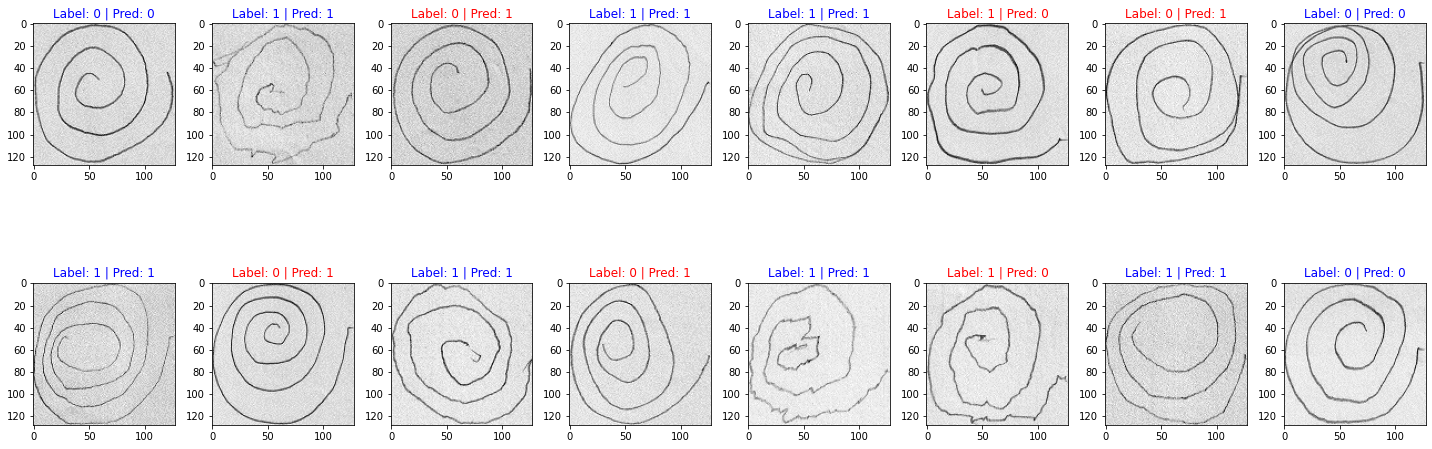

In [289]:
# Plot test_array images
check_val_images = []
test_label_array = np.array(test_label)
if len(test_label_array) == 16:
    rows = 2
    cols = 8
else:
    rows = 3
    cols = 5

plotImages(test_array, test_label_array, rows, cols)

## Heatmap Grad-CAM

In [282]:
## plot the heatmap images
def plotHeatmapImages(images_arr, label, rows, cols):
    count = 0
    fig, axes = plt.subplots(rows, cols, figsize=(20,8))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        #newImg=tf.image.rgb_to_hsv(img)

        ## ----------------------------------------------------------------------------------------------
        ##                                      OBTIAN HEATMAP IMAGE
        ## ----------------------------------------------------------------------------------------------
        testImg = np.expand_dims(test_array[count], axis=0)
        testImg_pp = preprocess_input(testImg)

        with tf.GradientTape() as tape:
            last_conv_layer = testModel.get_layer('conv2d_44')
            iterate = tf.keras.models.Model([testModel.inputs], [testModel.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(testImg_pp)
            class_out = model_out[:, np.argmax(model_out[0])]
            grads = tape.gradient(class_out, last_conv_layer)
            pooled_grads = K.mean(grads, axis=(0, 1, 2))
        
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = heatmap.reshape((27, 27))
        # plt.matshow(heatmap)
        # plt.show()

        origImg = Image.fromarray(np.squeeze(testImg))
        rgbImg = origImg.convert("RGB")

        INTENSITY = 0.75
        heatmap = cv2.resize(heatmap, (128, 128))
        heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

        heatImg = np.round((heatmap * INTENSITY + rgbImg) / (255*2) * 255).astype(np.uint8)
        # ----------------------------------------------------------------------------------------------
        # ----------------------------------------------------------------------------------------------

        ax.imshow(heatImg) 
        predImg = testModel.predict(np.expand_dims(test_array[count], axis=0))
        predLabel = np.argmax(predImg[0])       
        
        if label[count] != predLabel:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color='red')
        else:
            ax.set_title('Label: ' + str(label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

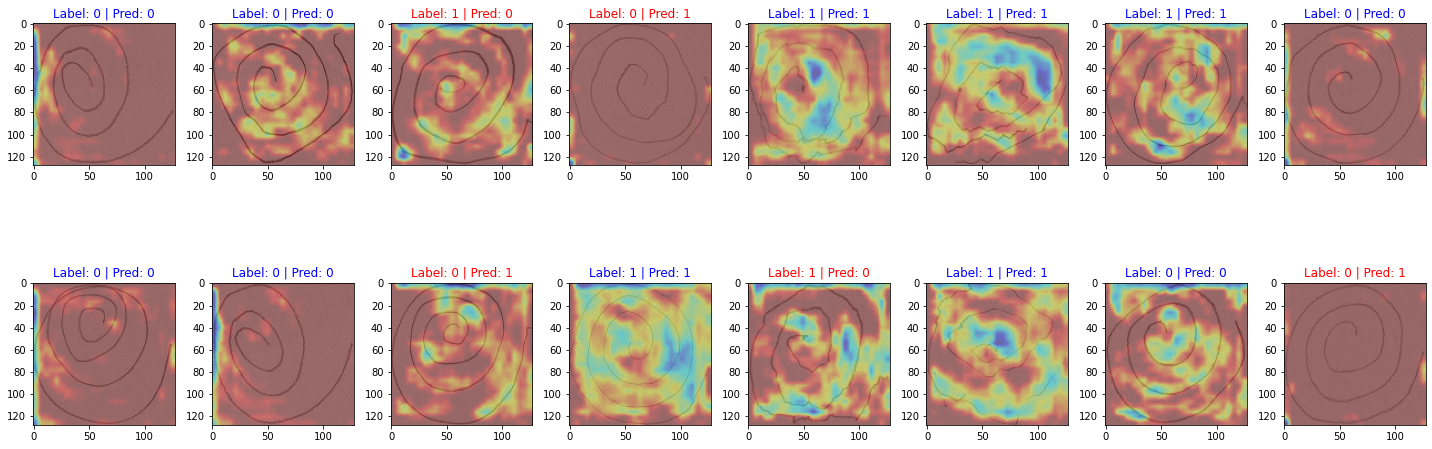

In [302]:
# Plot test_array heatmap images
check_val_images = []
test_label_array = np.array(test_label)
if len(test_label_array) == 16:
    rows = 2
    cols = 8
else:
    rows = 3
    cols = 5

plotHeatmapImages(test_array, test_label_array, rows, cols)

### Archive Code

In [7]:
newModel = tf.keras.models.load_model("h5model.h5")

newModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [ ]:
# predict an original image
predImg = testModel.predict(np.expand_dims(test_array[1], axis=0))
predLabel = np.argmax(predImg[0])

if predLabel == 1:
    print("Predicted Label: Parkinson's Disease")
else:
    print("Predicted Label: Healthy")

if np.array(test_label)[1] == 1:
    print("Actual Label: Parkinson's Disease")
else:
    print("Actual Label: Healthy")

# imfile = Image.fromarray(np.squeeze(val_array[4]))
# imfile.show(imfile)  
# 
plt.imshow(test_array[1]) 

In [356]:
## View heatmap for XAI
testImg = np.expand_dims(test_array[1], axis=0)
testImg_pp = preprocess_input(testImg)

testImgPred = testModel.predict(testImg_pp)

with tf.GradientTape() as tape:
  last_conv_layer = testModel.get_layer('conv2d_44')
  iterate = tf.keras.models.Model([testModel.inputs], [testModel.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(testImg_pp)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((27, 27))
# plt.matshow(heatmap)
# plt.show()

origImg = Image.fromarray(np.squeeze(testImg))
rgbImg = origImg.convert("RGB")
rgbImg = np.array(rgbImg)

INTENSITY = .5
heatmap = cv2.resize(heatmap, (128, 128))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
plt.matshow(heatmap)

# heatImg = np.round((heatmap * INTENSITY + rgbImg) / (255*2) * 255).astype(np.uint8)
heatImg = heatmap * INTENSITY + rgbImg
# heatImg = heatmap * INTENSITY + rgbImg
# print(heatImg[0])
# print(heatImg.astype(np.uint8)[0])

plt.matshow(heatImg/(255*2))
plt.show()

# plt.imshow(heatImg)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'cv::colormap::ColorMap::operator ()'


In [349]:
rgbImg

array([[[214, 214, 214],
        [204, 204, 204],
        [216, 216, 216],
        ...,
        [213, 213, 213],
        [214, 214, 214],
        [214, 214, 214]],

       [[216, 216, 216],
        [214, 214, 214],
        [213, 213, 213],
        ...,
        [204, 204, 204],
        [204, 204, 204],
        [214, 214, 214]],

       [[213, 213, 213],
        [213, 213, 213],
        [205, 205, 205],
        ...,
        [213, 213, 213],
        [205, 205, 205],
        [214, 214, 214]],

       ...,

       [[223, 223, 223],
        [205, 205, 205],
        [214, 214, 214],
        ...,
        [205, 205, 205],
        [203, 203, 203],
        [213, 213, 213]],

       [[205, 205, 205],
        [214, 214, 214],
        [205, 205, 205],
        ...,
        [204, 204, 204],
        [205, 205, 205],
        [204, 204, 204]],

       [[214, 214, 214],
        [214, 214, 214],
        [214, 214, 214],
        ...,
        [207, 207, 207],
        [202, 202, 202],
        [213, 213, 213]]